In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import fsolve

In [3]:
# Change

img = "harold.jpg"
mtx = np.array([[2.819553679831719251e+02, 0.000000000000000000e+00, 3.262468506102194397e+02],
                [0.000000000000000000e+00, 2.810872370991155549e+02, 2.079618310698781727e+02],
                [0.000000000000000000e+00, 0.000000000000000000e+00, 1.000000000000000000e+00]])
dist = np.array([-2.907715721478895121e-01, 9.026962260361984236e-02, -1.148611991451896396e-03, 8.210446409115852728e-05, -1.226467727111531236e-02])


In [4]:
# Constants

dictionaries = [
            cv2.aruco.DICT_7X7_100, 
            cv2.aruco.DICT_APRILTAG_36h11,
            cv2.aruco.DICT_ARUCO_MIP_36h12,
            ]

parameters =  cv2.aruco.DetectorParameters()

# Unique marker keys with (x, x, z (in mm), length_of_square (in m))
markers = {
    # window
    # "36H11_
    "79": (-4500, 1060 + 3000 + 50, 510, 0.08, "window"),
    # "36H11_
    "26": (-4500 + 450, 130 + 1060 + 3000 + 50, 1080, 0.235, "window"),
    # "36H12_
    "67": (-4500 + 450 + 530 + 80, 130 + 1060 + 3000 + 50, 1000, 0.2, "window"),
    # "36H11_
    "69": (-1800, 620 + 3000 + 50, 500, 0.08, "window"),
    # "36H11_
    "18": (0, 130 + 1060 + 3000 + 50, 1050, 0.28, "window"),
    # "36H12_
    "47": (840, 130 + 1060 + 3000 + 50, 1050, 0.2, "window"),
    # "36H11_
    "9": (840 + 850, 1060 + 3000 + 50, 500, 0.08, "window"),
    # "36H11_
    "66": (840 + 850 + 1150, 130 + 1060 + 3000 + 50, 1100, 0.235, "window"),


    # tables
    # "36H11_
    "39": (4500, 1100, 500, 0.08, "tables"),
    # "36H11_
    "46": (4550 + 820, 0, 1680, 0.235, "tables"),  # the one up
    # "36H12_
    "57": (4550 + 820, 0, 1000, 0.2, "tables"),  # the lower one
    # "36H11_
    "49": (4500, -1100, 500, 0.08, "tables"),


    # wall
    # "36H11_
    "16": (2850, -2000 - 3005, 1070, 0.235, "wall"),
    # "36H11_
    "19": (2850 - 1050, -2000 - 3005, 510, 0.08, "wall"),
    # "7x7_
    "37": (2850 - 1050 - 850, -2000 - 3005, 1000, 0.2, "wall"),
    # "36H11_
    "29": (2850 - 1050 - 850 - 1050, -2000 - 3005, 500, 0.08, "wall"),  # one on the bottom
    # "36H11_
    "8": (2850 - 1050 - 850 - 1050, -2000 - 3005, 1060, 0.275, "wall"),  # one on top
    # "36H11_
    "59": (-2800 + 1050, -120 - 3005, 510, 0.08, "wall"),  # column one
    # "7x7_
    "27": (-2800, -2000 - 3005, 1000, 0.2, "wall"),  #
    # "36H11_
    "36": (-2800 - 900, -2000 - 3005, 1080, 0.235, "wall"),


    # ducks
    # "7x7_
    "7": (-4600 - 50 - 930, 0, 1680, 0.2, "ducks"),  # lower one in column
    # "36H11_
    "56": (-4600 - 50 - 930, 0, 1000, 0.235, "ducks"),  # top one in column
    # "36H11_
    "89": (-4500, -1100, 450, 0.08, "ducks"),
    # "36H11_
    "99": (-4500, 1100, 500, 0.08, "ducks"),  # window
}



In [5]:
# Functions

def triangulate_3d(x_A, y_A, z_A, d_A, x_B, y_B, z_B, d_B):
    A = -2 * (x_A - x_B)
    B = -2 * (y_A - y_B)
    C = d_A**2 - z_A**2 - d_B**2 + z_B**2 - x_A**2 + x_B**2 - y_A**2 + y_B**2

    if B == 0:        
        x1 = C / A
        x2 = C/A

        a = 1
        b = -2 * y_B
        c = (x1**2 - 2*x1 * x_B + x_B**2) + y_B**2 + z_B**2 - d_B**2
        root = b**2 - 4*a*c
        if root >=0:
            y1 = (-b + np.sqrt(b**2 - 4*a*c)) / (2*a)
            y2 = (-b - np.sqrt(b**2 - 4*a*c)) / (2*a)
        else:
            print("Coudln't find match")
            return None

    else:
        a = 1 + A**2/B**2
        b = -2*(x_A + A*C/B**2 - y_A * A/B)
        c = x_A**2 + z_A**2 -d_A**2 - 2*y_A*C/B + (C/B)**2 + y_A**2

        x1 = (-b + np.sqrt(b**2 - 4*a*c)) / (2*a)
        x2 = (-b - np.sqrt(b**2 - 4*a*c)) / (2*a)

        if d_B**2 - z_B**2 - (x1-x_B)**2 >= 0 and d_B**2 - z_B**2 - (x2-x_B)**2 >0:
            y1 = y_B + np.sqrt(d_B**2 - z_B**2 - (x1-x_B)**2)
            y2 = y_B + np.sqrt(d_B**2 - z_B**2 - (x2-x_B)**2)
        else:
            print("Coudln't find match because they don't intersect")
            return None

    return (x1, y1), (x2, y2)


def get_robot_global_coords(marker_global_coords, rvecs, tvecs):
    R, _ = cv2.Rodrigues(rvecs)
    t = tvecs.reshape(3, 1)
    
    cam_to_marker = np.eye(4)
    cam_to_marker[:3, :3] = R
    cam_to_marker[:3, 3] = t.flatten()
    
    marker_to_cam = np.eye(4)
    marker_to_cam[:3, :3] = R.T
    marker_to_cam[:3, 3] = -R.T @ t.flatten()
    
    marker_to_global = np.eye(4)
    marker_to_global[:3, 3] = marker_global_coords[:3]
    
    cam_to_global = marker_to_global @ marker_to_cam
    
    robot_global_coords = cam_to_global[:3, 3]
    return robot_global_coords

def twopointstriangulation(x_A, y_A, z_A, d_A, x_B, y_B, z_B, d_B):
    return triangulate_3d(x_A, y_A, z_A, d_A, x_B, y_B, z_B, d_B)

def compute_triangulation(markers_in_img):
    pairs = []
    for i in range(len(markers_in_img)):
        for j in range(i + 1, len(markers_in_img)):
            pairs.append((i, j))

    points = []
    
    for (idx_A, idx_B) in pairs:
        print("Pair",markers_in_img[idx_A][3], markers_in_img[idx_B][3])
        x_A, y_A, z_A = markers_in_img[idx_A][1][:3]
        x_B, y_B, z_B = markers_in_img[idx_B][1][:3]
        d_A = markers_in_img[idx_A][2]
        d_B = markers_in_img[idx_B][2]
        out = twopointstriangulation(x_A, y_A, z_A, d_A, x_B, y_B, z_B, d_B)
        if out != None:
            (x1, y1), (x2, y2) = out
            if abs(y1) > 6000 or abs(x1) > 9000:
                print("Point",markers_in_img[idx_A][3],":", x_A, y_A, z_A, d_A)
                print("Point",markers_in_img[idx_B][3],":", x_B, y_B, z_B, d_B)
                print("Chosen", x2,y2)
                points.append([x2,y2,0])
            elif abs(y2) > 6000 or abs(x2) > 9000:
                print("Point",markers_in_img[idx_A][3],":", x_A, y_A, z_A, d_A)
                print("Point",markers_in_img[idx_B][3],":", x_B, y_B, z_B, d_B)
                print("Chosen", x1,y1)
                points.append([x1,y1,0])
            else:
                print("Discarted pair because out of field")
        print("")
        
    if len(points)!=0:
        return np.array(points).mean(axis=0)
    else:
        return []


def detect_and_locate_old(image):
    markers_in_img = []
    ids = []
    markers_2D_coords = []
    for dictionar in dictionaries:
        dictionary = cv2.aruco.getPredefinedDictionary(dictionar)
        detector = cv2.aruco.ArucoDetector(dictionary, parameters)
        markerCorners_dict, markerIds_dict, _ = detector.detectMarkers(image)
        if markerCorners_dict:
            for markerCorner, markerId in zip(markerCorners_dict, markerIds_dict):
                if any(np.array_equal(markerCorner, mar[0]) for mar in markers_in_img):
                    continue
                else:
                    if str(markerId[0]) in markers.keys():
                        markerLength = markers[str(markerId[0])][3]
                        print("MarkerId:", markerId[0], ", Marker coordinates + length:", markers[str(markerId[0])]) #markerLength)
                        coords = markerCorner[0]
                        for coord in coords:
                            markers_2D_coords.append(coord)
                        ids.append(markerId[0])
                        _, tvecs, _ = cv2.aruco.estimatePoseSingleMarkers(markerCorner, markerLength, mtx, dist) #in meters bc markerLength is in meter
                        distance = np.linalg.norm(tvecs)*1000
                        print("Distance:", distance)
                        marker_global_coordinates = markers[str(markerId[0])][:3]
                        print("Marker global coord:", marker_global_coordinates)
                        markers_in_img.append([markerCorner, markers[str(markerId[0])], distance, markerId[0]]) 
                        
                        print("")
    if len(markers_in_img)>=2:
        print("")
        print("--------------")
        print("")
        out = compute_triangulation(markers_in_img)
        print("out:",out)
        if len(out) != 0:
            x, y, z = out
            return (x, y, z), markers_2D_coords, ids
        else:
            return (None, None, None), markers_2D_coords, ids
    else:
        return (None, None, None), markers_2D_coords, ids
    

    
        
# %reload_ext autoreload
# %autoreload 2
from astar import PathFinder

import matplotlib.pyplot as plt
from matplotlib import patches

# Dimensions in mm
A = 9000  # Field length
B = 6000  # Field width
C = 50  # Line width
D = 100  # Penalty mark size
E = 600  # Goal area length
F = 2200  # Goal area width
G = 1650  # Penalty area length
H = 4000  # Penalty area width
I = 1300  # Penalty mark distance
J = 1500  # Center circle diameter
K = 2700  # Border strip width

duck_locations = (
    (G, (B + H) / 2),
    (G, (B - H) / 2),
    (E, (B + F) / 2),
    (E, (B - F) / 2),
    (I, B / 2),
)


def detect_and_plot(image, plot = True, points=[], ids=[]):
    parameters =  cv2.aruco.DetectorParameters()
    info = []
    rejectedCandidates=[]

    for d, dictionar in enumerate(dictionaries):
        dictionary = cv2.aruco.getPredefinedDictionary(dictionar)
        detector = cv2.aruco.ArucoDetector(dictionary, parameters)
        markerCorner, markerId, rejectedCandidate = detector.detectMarkers(image)
        markerLength = 0.1 #markerLengthdic[str(dictionar)]
        rvecs, tvecs, _ = cv2.aruco.estimatePoseSingleMarkers(markerCorner, markerLength, mtx, dist)
        if markerCorner:
            for corner,Id, r in zip(markerCorner, markerId, rejectedCandidate):
                # print(len(info))
                # print(Id)        
                info.append([corner,Id, rvecs, tvecs])

        if rejectedCandidate:
            rejectedCandidates.append(rejectedCandidate)
        
    print("Number of detected markers:", len(ids))
    # print("Number of rejected candidates:", len(rejectedCandidates))
    
    points = [tuple(map(int, point)) for point in points]
    if plot:
        for candidate, Id, _, _ in info:
                candidate = np.array(candidate)[0].reshape((4, 2))  # Get the 4 corner points
                if tuple(map(int, candidate[0])) in points:
                    for i in range(4):
                        # Convert to integers
                        pt1 = tuple(map(int, candidate[i]))
                        pt2 = tuple(map(int, candidate[(i + 1) % 4]))
                        cv2.line(image, pt1, pt2, (0,255, 0), 5)
                pt1 =  tuple(map(int, candidate[0]))
                if Id is not None and Id in ids:
                    # Annotate marker ID near the first corner with highlighted text
                    text = str(Id[0])
                    font = cv2.FONT_HERSHEY_SIMPLEX
                    font_scale = 0.6
                    thickness = 2
                    text_size = cv2.getTextSize(text, font, font_scale, thickness)[0]
                    text_origin = (pt1[0], pt1[1] - 5)  # Adjust Y to position above the corner

                    # Draw background rectangle
                    cv2.rectangle(image, 
                                (text_origin[0], text_origin[1] - text_size[1] - 5), 
                                (text_origin[0] + text_size[0], text_origin[1] + 20), 
                                (255, 255, 255), 
                                -1)
                    cv2.putText(image, str(Id[0]), pt1, cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 0), 2)
                

                # # Optionally, draw a circle at each corner for visibility
                # for point in candidate:
                #     pt = tuple(map(int, point))
                #     cv2.circle(image, pt, 1, (0, 0, 255), -1)
                
        plt.figure(figsize=(10, 10))
        plt.imshow(image)
        plt.axis('off')
        plt.show()
    return info


def visualize_field(xrobot, yrobot):
    # Create figure and axis
    fig, ax = plt.subplots(figsize=(10, 6))
    fig.patch.set_facecolor("green")  # Set the background color to green

    # Draw the outer field
    outer_field = patches.Rectangle(
        (0, 0), A, B, linewidth=C / 10, edgecolor="white", facecolor="none"
    )
    ax.add_patch(outer_field)

    # Goal areas
    goal_area_left = patches.Rectangle(
        (0, (B - F) / 2), E, F, linewidth=C / 10, edgecolor="white", facecolor="none"
    )
    goal_area_right = patches.Rectangle(
        (A - E, (B - F) / 2),
        E,
        F,
        linewidth=C / 10,
        edgecolor="white",
        facecolor="none",
    )
    ax.add_patch(goal_area_left)
    ax.add_patch(goal_area_right)

    # Penalty areas
    penalty_area_left = patches.Rectangle(
        (0, (B - H) / 2), G, H, linewidth=C / 10, edgecolor="white", facecolor="none"
    )
    penalty_area_right = patches.Rectangle(
        (A - G, (B - H) / 2),
        G,
        H,
        linewidth=C / 10,
        edgecolor="white",
        facecolor="none",
    )
    ax.add_patch(penalty_area_left)
    ax.add_patch(penalty_area_right)

    # Penalty marks
    ax.plot(I, B / 2, "wo", markersize=D / 10)  # Left penalty mark
    ax.plot(A - I, B / 2, "wo", markersize=D / 10)  # Right penalty mark

    # Center circle
    center_circle = patches.Circle(
        (A / 2, B / 2), J / 2, linewidth=C / 10, edgecolor="white", facecolor="none"
    )
    ax.add_patch(center_circle)
    ax.plot(A / 2, B / 2, "wo", markersize=D / 10)  # Center mark

    # Halfway line
    ax.plot([A / 2, A / 2], [0, B], "white", linewidth=C / 10)

    # Plot the ducks
    # For some reason hides the center point
    ax.scatter(*list(zip(*duck_locations)), D, "yellow", zorder=2.5)

    # Robot position
    if xrobot != None:
        ax.plot(int(xrobot) +A/2,int(yrobot) +B/2, "ro", zorder=5)
    else:
        print("Robot coudln't be located")

    # Plot the markers on the field
    for marker, (x, y, z, _, _) in markers.items():
        # Convert (x, y) to pixel coordinates
        x  # *= 1000
        y  # *=1000
        x_img = int((x + A / 2))
        y_img = int((y + B / 2))

        # Draw a blue circle for each marker
        ax.plot(x_img, y_img, "bo", markersize=5)
        ax.text(x_img, y_img-400, marker)

    # Set the limits and aspecs
    ax.set_xlim(-K, A + K)
    ax.set_ylim(-K, B + K)
    ax.set_aspect("equal", adjustable="box")
    ax.axis("off")  # Turn off axe
    return fig, ax

In [6]:
# Localization
image = cv2.imread(img)
blurred = cv2.GaussianBlur(image, (3, 3), 5)
image = cv2.addWeighted(image, 3, blurred, -2, 0)

sharpen_filter = np.array(
    [[-1, -1, -1, -1], [-1, 9, 9, -1], [-1, 9, 9, -1], [-1, -1, -1, -1]]
)
sharpened = cv2.filter2D(image, cv2.CV_8U, sharpen_filter)
image = cv2.addWeighted(image, 1.5, sharpened, -0.25, 0)
(average_x, average_y, average_z), markers_2D_coords, ids = detect_and_locate_old(image)
print("Results:", average_x, average_y, average_z)

MarkerId: 37 , Marker coordinates + length: (950, -5005, 1000, 0.2, 'wall')
Distance: 2678.8222926319695
Marker global coord: (950, -5005, 1000)

MarkerId: 8 , Marker coordinates + length: (-100, -5005, 1060, 0.275, 'wall')
Distance: 2471.2258146016243
Marker global coord: (-100, -5005, 1060)

MarkerId: 16 , Marker coordinates + length: (2850, -5005, 1070, 0.235, 'wall')
Distance: 2722.006241261658
Marker global coord: (2850, -5005, 1070)


--------------

Pair 37 8
Point 37 : 950 -5005 1000 2678.8222926319695
Point 8 : -100 -5005 1060 2471.2258146016243
Chosen -142.96754702311364 -2773.070158661729

Pair 37 16
Point 37 : 950 -5005 1000 2678.8222926319695
Point 16 : 2850 -5005 1070 2722.006241261658
Chosen 1876.7554994827842 -2699.091693132528

Pair 8 16
Point 8 : -100 -5005 1060 2471.2258146016243
Point 16 : 2850 -5005 1070 2722.006241261658
Chosen 1157.8710253027189 -3160.7881058681614

out: [  963.88632592 -2877.64998589     0.        ]
Results: 963.8863259207965 -2877.6499858874727


Number of detected markers: 3


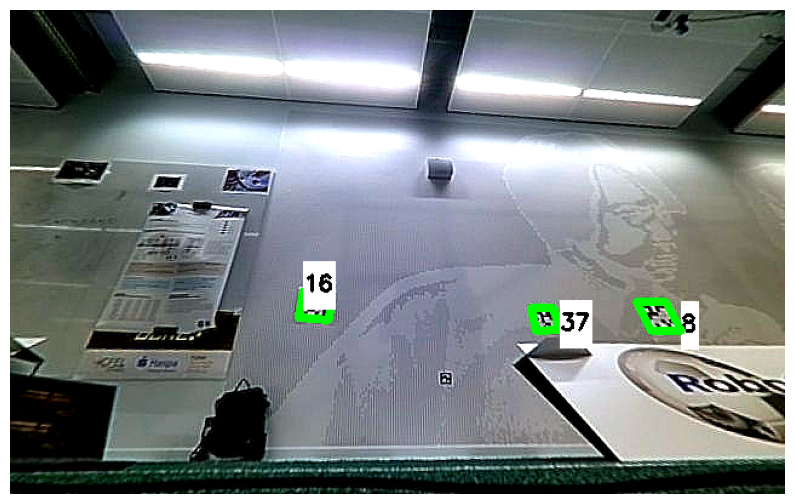

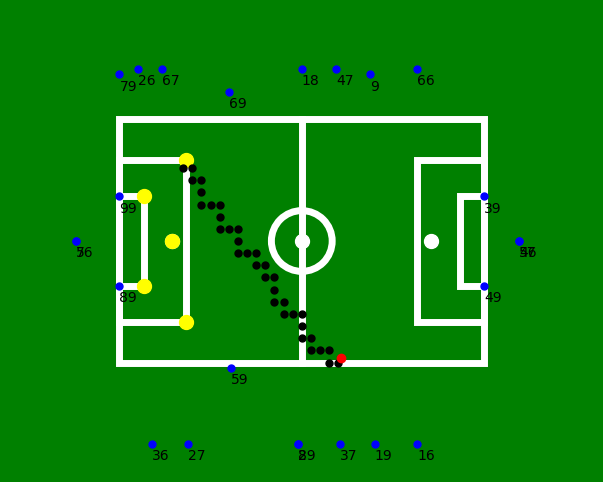

In [7]:
print("")
_ = detect_and_plot(image, points = markers_2D_coords, ids = ids)
fig, ax = visualize_field(average_x, average_y)

def select_duck(duck_locations, idx):
    return duck_locations[idx], duck_locations[:idx] + duck_locations[idx + 1 :]

if average_x != None:
    start = (average_x + A/2,average_y + B/2)

    # Select the first duck
    goal, obstacles = select_duck(duck_locations, 0)

    pathfinder = PathFinder(40, 20, A, B)
    path_coordinates, debug = pathfinder.find_path(start, goal, obstacles, distance_metric="euclidian", debug=True)

    ax.scatter(*list(zip(*path_coordinates)), C / 2, "k", zorder=3)
